In [1]:
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

print("="*80)
print("军事通信效能评估系统 - 组合赋权法")
print("="*80)
print(f"评估时间: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print()

军事通信效能评估系统 - 组合赋权法
评估时间: 2026-02-09 17:22:51



In [2]:
DB_CONFIG = {
    'host': 'localhost',
    'user': 'root',
    'password': 'root',
    'database': 'military_communication_effectiveness',
    'charset': 'utf8mb4'
}

def get_db_connection():
    """获取数据库连接"""
    return mysql.connector.connect(**DB_CONFIG)

def extract_indicators_from_raw_tables():
    """
    从原始表中提取20个指标
    整合 during_battle_communications 和 communication_network_lifecycle 表的数据
    
    返回:
        DataFrame: 包含20个指标的数据框
    """
    conn = get_db_connection()
    
    # SQL查询1: 从 during_battle_communications 表聚合数据
    query_dbc = """
    SELECT 
        test_id,
        scenario_id,
        
        -- C1. 响应能力 (RS)
        AVG(call_setup_duration_ms) as RS_avg_call_setup_duration_ms,
        AVG(transmission_delay_ms) as RS_avg_transmission_delay_ms,
        
        -- C2. 处理能力 (PO)
        AVG(instant_throughput) as PO_effective_throughput,
        AVG(instant_throughput / channel_bandwidth) as PO_spectral_efficiency,
        
        -- C3. 有效性 (EF)
        AVG(communication_distance) as EF_avg_communication_distance,
        AVG(instant_ber) as EF_avg_ber,
        AVG(instant_plr) as EF_avg_plr,
        SUM(CASE WHEN communication_success = 1 THEN 1 ELSE 0 END) / COUNT(*) as EF_task_success_rate,
        
        -- C4. 可靠性 (RL) - 部分指标
        SUM(CASE WHEN communication_success = 1 THEN 1 ELSE 0 END) / COUNT(*) as RL_communication_success_rate,
        
        -- C5. 抗干扰性 (AJ)
        AVG(instant_sinr) as AJ_avg_sinr,
        AVG(jamming_margin) as AJ_avg_jamming_margin,
        
        -- C6. 人为操作 (HO)
        AVG(operator_reaction_time_ms) as HO_avg_operator_reaction_time_ms,
        SUM(CASE WHEN operation_error = 0 THEN 1 ELSE 0 END) / COUNT(*) as HO_operation_success_rate,
        
        -- C8. 安全性 (SC)
        SUM(CASE WHEN key_updated = 1 THEN 1 ELSE 0 END) / 
            NULLIF(SUM(communication_duration_ms) / 3600000.0, 0) as SC_key_compromise_frequency,
        SUM(CASE WHEN detected = 1 THEN 1 ELSE 0 END) / COUNT(*) as SC_detection_probability,
        1 - (SUM(CASE WHEN intercepted = 1 THEN 1 ELSE 0 END) / 
            NULLIF(COUNT(*), 0)) as SC_interception_resistance,
        
        -- 统计信息
        COUNT(*) as total_communications
        
    FROM during_battle_communications
    GROUP BY test_id, scenario_id
    ORDER BY test_id
    """
    
    # SQL查询2: 从 communication_network_lifecycle 表聚合数据
    query_lc = """
    SELECT 
        test_id,
        scenario_id,
        
        -- C4. 可靠性 (RL) - 剩余指标
        (SUM(total_lifecycle_duration_ms) - COALESCE(SUM(total_interruption_duration_ms), 0)) / 
            NULLIF(SUM(total_lifecycle_duration_ms), 0) as RL_communication_availability_rate,
        AVG(CASE WHEN network_crash_occurred = 1 THEN total_interruption_duration_ms ELSE NULL END) as RL_recovery_duration_ms,
        SUM(CASE WHEN network_crash_occurred = 1 THEN 1 ELSE 0 END) / COUNT(*) as RL_crash_rate,
        
        -- C7. 组网能力 (NC)
        AVG(network_setup_duration_ms) as NC_avg_network_setup_duration_ms,
        AVG(connectivity_rate) as NC_avg_connectivity_rate,
        
        -- 统计信息
        COUNT(*) as total_lifecycles
        
    FROM communication_network_lifecycle
    GROUP BY test_id, scenario_id
    ORDER BY test_id
    """
    
    # 执行查询
    df_dbc = pd.read_sql(query_dbc, conn)
    df_lc = pd.read_sql(query_lc, conn)
    conn.close()
    
    # 合并两个数据框
    df_merged = pd.merge(df_dbc, df_lc, on=['test_id', 'scenario_id'], how='left')
    
    # 处理缺失值
    df_merged['RL_communication_availability_rate'] = df_merged['RL_communication_availability_rate'].fillna(1.0)
    df_merged['RL_recovery_duration_ms'] = df_merged['RL_recovery_duration_ms'].fillna(0)
    df_merged['RL_crash_rate'] = df_merged['RL_crash_rate'].fillna(0)
    df_merged['NC_avg_connectivity_rate'] = df_merged['NC_avg_connectivity_rate'] / 100.0  # 转换为0-1
    
    return df_merged

print("步骤1: 从原始表提取20个评估指标")
print("-"*80)

# 从原始表提取数据
df_raw = extract_indicators_from_raw_tables()

print(f"✓ 成功从 during_battle_communications 表提取数据")
print(f"✓ 成功从 communication_network_lifecycle 表提取数据")
print(f"✓ 合并后共 {len(df_raw)} 个测试批次")
print(f"✓ 包含 21 个评估指标")
print()

# 显示提取的数据预览
print("提取的数据预览:")
preview_cols = ['test_id', 'RS_avg_call_setup_duration_ms', 'PO_effective_throughput', 
                'RL_crash_rate', 'SC_detection_probability', 'total_communications']
print(df_raw[preview_cols].to_string(index=False))
print()

步骤1: 从原始表提取20个评估指标
--------------------------------------------------------------------------------
✓ 成功从 during_battle_communications 表提取数据
✓ 成功从 communication_network_lifecycle 表提取数据
✓ 合并后共 10 个测试批次
✓ 包含 21 个评估指标

提取的数据预览:
      test_id  RS_avg_call_setup_duration_ms  PO_effective_throughput  RL_crash_rate  SC_detection_probability  total_communications
TEST-2026-001                    1521.608846             31294.087308         0.0000                    0.0385                    26
TEST-2026-002                    1447.931115             25623.263077         0.0000                    0.0000                    26
TEST-2026-003                    1381.833905             26080.912857         0.6667                    0.0000                    21
TEST-2026-004                    1517.714550             27383.045000         0.0000                    0.2000                    20
TEST-2026-005                    1531.415320             25776.820800         0.0000                    0.0400

In [3]:
print("存储评估数据到数据库")
print("-"*80)

def save_to_database(df_raw):
    """
    将原始指标数据和评估结果存储到 military_effectiveness_evaluation 表
    
    参数:
        df_raw: 原始指标数据
    """
    conn = get_db_connection()
    cursor = conn.cursor()
    
    # 准备插入数据
    insert_count = 0
    update_count = 0
    
    for idx, row in df_raw.iterrows():
        test_id = row['test_id']
        scenario_id = row['scenario_id']
        
        # 检查是否已存在
        cursor.execute("SELECT evaluation_id FROM military_effectiveness_evaluation WHERE test_id = %s", (test_id,))
        existing = cursor.fetchone()
        
        if existing:
            # 更新现有记录
            update_sql = """
            UPDATE military_effectiveness_evaluation SET
                scenario_id = %s,
                RS_avg_call_setup_duration_ms = %s,
                RS_avg_transmission_delay_ms = %s,
                PO_effective_throughput = %s,
                PO_spectral_efficiency = %s,
                EF_avg_communication_distance = %s,
                EF_avg_ber = %s,
                EF_avg_plr = %s,
                EF_task_success_rate = %s,
                RL_communication_availability_rate = %s,
                RL_communication_success_rate = %s,
                RL_recovery_duration_ms = %s,
                RL_crash_rate = %s,
                AJ_avg_sinr = %s,
                AJ_avg_jamming_margin = %s,
                HO_avg_operator_reaction_time_ms = %s,
                HO_operation_success_rate = %s,
                NC_avg_network_setup_duration_ms = %s,
                NC_avg_connectivity_rate = %s,
                SC_key_compromise_frequency = %s,
                SC_detection_probability = %s,
                SC_interception_resistance = %s,
                total_communications = %s,
                total_lifecycles = %s,
                updated_at = CURRENT_TIMESTAMP
            WHERE test_id = %s
            """
            
            cursor.execute(update_sql, (
                scenario_id,
                row['RS_avg_call_setup_duration_ms'],
                row['RS_avg_transmission_delay_ms'],
                row['PO_effective_throughput'],
                row['PO_spectral_efficiency'],
                row['EF_avg_communication_distance'],
                row['EF_avg_ber'],
                row['EF_avg_plr'],
                row['EF_task_success_rate'],
                row['RL_communication_availability_rate'],
                row['RL_communication_success_rate'],
                row['RL_recovery_duration_ms'],
                row['RL_crash_rate'],
                row['AJ_avg_sinr'],
                row['AJ_avg_jamming_margin'],
                row['HO_avg_operator_reaction_time_ms'],
                row['HO_operation_success_rate'],
                row['NC_avg_network_setup_duration_ms'],
                row['NC_avg_connectivity_rate'],
                row['SC_key_compromise_frequency'],
                row['SC_detection_probability'],
                row['SC_interception_resistance'],
                row['total_communications'],
                row['total_lifecycles'],
                test_id
            ))
            update_count += 1
        else:
            # 插入新记录
            insert_sql = """
            INSERT INTO military_effectiveness_evaluation (
                scenario_id, test_id,
                RS_avg_call_setup_duration_ms, RS_avg_transmission_delay_ms,
                PO_effective_throughput, PO_spectral_efficiency,
                EF_avg_communication_distance, EF_avg_ber, EF_avg_plr, EF_task_success_rate,
                RL_communication_availability_rate, RL_communication_success_rate,
                RL_recovery_duration_ms, RL_crash_rate,
                AJ_avg_sinr, AJ_avg_jamming_margin,
                HO_avg_operator_reaction_time_ms, HO_operation_success_rate,
                NC_avg_network_setup_duration_ms, NC_avg_connectivity_rate,
                SC_key_compromise_frequency, SC_detection_probability, SC_interception_resistance,
                total_communications, total_lifecycles
            ) VALUES (
                %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s
            )
            """
            
            cursor.execute(insert_sql, (
                scenario_id, test_id,
                row['RS_avg_call_setup_duration_ms'],
                row['RS_avg_transmission_delay_ms'],
                row['PO_effective_throughput'],
                row['PO_spectral_efficiency'],
                row['EF_avg_communication_distance'],
                row['EF_avg_ber'],
                row['EF_avg_plr'],
                row['EF_task_success_rate'],
                row['RL_communication_availability_rate'],
                row['RL_communication_success_rate'],
                row['RL_recovery_duration_ms'],
                row['RL_crash_rate'],
                row['AJ_avg_sinr'],
                row['AJ_avg_jamming_margin'],
                row['HO_avg_operator_reaction_time_ms'],
                row['HO_operation_success_rate'],
                row['NC_avg_network_setup_duration_ms'],
                row['NC_avg_connectivity_rate'],
                row['SC_key_compromise_frequency'],
                row['SC_detection_probability'],
                row['SC_interception_resistance'],
                row['total_communications'],
                row['total_lifecycles']
            ))
            insert_count += 1
    
    conn.commit()
    cursor.close()
    conn.close()
    
    return insert_count, update_count

try:
    insert_count, update_count = save_to_database(df_raw)
    print(f"✓ 数据存储成功")
    print(f"  - 新增记录: {insert_count} 条")
    print(f"  - 更新记录: {update_count} 条")
    print(f"  - 总计: {insert_count + update_count} 条")
except Exception as e:
    print(f"✗ 数据存储失败: {str(e)}")

存储评估数据到数据库
--------------------------------------------------------------------------------
✓ 数据存储成功
  - 新增记录: 0 条
  - 更新记录: 10 条
  - 总计: 10 条


In [4]:
print("步骤2: 定义指标体系")
print("-"*80)

# 指标配置：维度 → 指标列表
INDICATOR_SYSTEM = {
    'RL': {  # 可靠性 - 优先级1
        'name': '可靠性',
        'priority': 1,
        'indicators': [
            {'code': 'RL_communication_availability_rate', 'name': '通信可用性', 'direction': 'max'},
            {'code': 'RL_communication_success_rate', 'name': '通信成功率', 'direction': 'max'},
            {'code': 'RL_recovery_duration_ms', 'name': '恢复时长', 'direction': 'min'},
            {'code': 'RL_crash_rate', 'name': '崩溃比例', 'direction': 'min'}
        ]
    },
    'SC': {  # 安全性 - 优先级2
        'name': '安全性',
        'priority': 2,
        'indicators': [
            {'code': 'SC_key_compromise_frequency', 'name': '密钥泄露频率', 'direction': 'min'},
            {'code': 'SC_detection_probability', 'name': '被侦察概率', 'direction': 'min'},
            {'code': 'SC_interception_resistance', 'name': '抗拦截能力', 'direction': 'max'}
        ]
    },
    'AJ': {  # 抗干扰性 - 优先级3
        'name': '抗干扰性',
        'priority': 3,
        'indicators': [
            {'code': 'AJ_avg_sinr', 'name': '平均信干噪比', 'direction': 'max'},
            {'code': 'AJ_avg_jamming_margin', 'name': '平均抗干扰余量', 'direction': 'max'}
        ]
    },
    'EF': {  # 有效性 - 优先级4
        'name': '有效性',
        'priority': 4,
        'indicators': [
            {'code': 'EF_avg_communication_distance', 'name': '平均通信距离', 'direction': 'max'},
            {'code': 'EF_avg_ber', 'name': '平均误码率', 'direction': 'min'},
            {'code': 'EF_avg_plr', 'name': '平均丢包率', 'direction': 'min'},
            {'code': 'EF_task_success_rate', 'name': '任务成功率', 'direction': 'max'}
        ]
    },
    'PO': {  # 处理能力 - 优先级5
        'name': '处理能力',
        'priority': 5,
        'indicators': [
            {'code': 'PO_effective_throughput', 'name': '有效吞吐量', 'direction': 'max'},
            {'code': 'PO_spectral_efficiency', 'name': '频谱效率', 'direction': 'max'}
        ]
    },
    'NC': {  # 组网能力 - 优先级6
        'name': '组网能力',
        'priority': 6,
        'indicators': [
            {'code': 'NC_avg_network_setup_duration_ms', 'name': '平均组网时长', 'direction': 'min'},
            {'code': 'NC_avg_connectivity_rate', 'name': '平均连通率', 'direction': 'max'}
        ]
    },
    'HO': {  # 人为操作 - 优先级7
        'name': '人为操作',
        'priority': 7,
        'indicators': [
            {'code': 'HO_avg_operator_reaction_time_ms', 'name': '平均操作员反应时间', 'direction': 'min'},
            {'code': 'HO_operation_success_rate', 'name': '操作成功率', 'direction': 'max'}
        ]
    },
    'RS': {  # 响应能力 - 优先级8
        'name': '响应能力',
        'priority': 8,
        'indicators': [
            {'code': 'RS_avg_call_setup_duration_ms', 'name': '平均呼叫建立时长', 'direction': 'min'},
            {'code': 'RS_avg_transmission_delay_ms', 'name': '平均传输时延', 'direction': 'min'}
        ]
    }
}

# 打印指标体系
print("指标体系（按主观优先级排序）:")
for dim_code in sorted(INDICATOR_SYSTEM.keys(), key=lambda x: INDICATOR_SYSTEM[x]['priority']):
    dim = INDICATOR_SYSTEM[dim_code]
    print(f"  {dim['priority']}. {dim_code} - {dim['name']} ({len(dim['indicators'])}个指标)")

print(f"\n总计: 8个维度, 21个指标")
print()

步骤2: 定义指标体系
--------------------------------------------------------------------------------
指标体系（按主观优先级排序）:
  1. RL - 可靠性 (4个指标)
  2. SC - 安全性 (3个指标)
  3. AJ - 抗干扰性 (2个指标)
  4. EF - 有效性 (4个指标)
  5. PO - 处理能力 (2个指标)
  6. NC - 组网能力 (2个指标)
  7. HO - 人为操作 (2个指标)
  8. RS - 响应能力 (2个指标)

总计: 8个维度, 21个指标



In [11]:
print("步骤3: 数据标准化（Z-score标准化）")
print("-"*80)
print("使用归一化方法: Z-score标准化")
print("说明: 所有指标统一使用Z-score标准化，适合计算熵权")
print("      极小值指标（误码率、丢包率）先进行对数变换")
print("      标准化后数据为标准正态分布（均值0，标准差1）")
print()

# 定义极小值指标（需要对数变换）
# 这些指标跨越多个数量级（10⁻⁶ ~ 10⁻²），需要对数变换将指数级差异转为线性差异
LOGARITHMIC_INDICATORS = {
    'EF_avg_ber',   # 误码率（10⁻⁵ ~ 10⁻³，跨3个数量级）
    'EF_avg_plr',   # 丢包率（10⁻⁴ ~ 10⁻²，跨2个数量级）
}

def normalize_indicator(series, direction, indicator_code=None):
    """
    Z-score标准化方法：所有指标都使用Z-score标准化
    
    处理流程：
    1. 极小值指标（误码率、丢包率）→ 先对数变换，将指数级差异转为线性差异
    2. 所有指标 → 统一使用Z-score标准化
    
    原理（Z-score标准化）:
        z = (x - mean) / std
        
        对于逆向指标（越小越好）：
        z = (mean - x) / std  （取反，使得越小的值z-score越大）
    
    参数:
        series: 指标数据序列
        direction: 'max'表示越大越好，'min'表示越小越好
        indicator_code: 指标代码，用于判断是否需要对数变换
    
    返回:
        标准化后的序列（均值0，标准差1）
    
    优点:
        - 消除量纲影响
        - 适合计算熵权
        - 保留数据分布特征
        - 对异常值不敏感
    """
    # 处理空值
    if series.isna().all():
        return pd.Series([0] * len(series), index=series.index)
    
    # 步骤1：预处理（对数变换）
    # 只对极小值指标进行对数变换，将指数级差异转为线性差异
    if indicator_code in LOGARITHMIC_INDICATORS:
        # 对数变换：-log10(value)
        # 误码率：10⁻⁵ → 5, 10⁻³ → 3
        # 丢包率：10⁻⁴ → 4, 10⁻² → 2
        series = -np.log10(series + 1e-10)  # 加极小值避免log(0)
    
    # 步骤2：Z-score标准化
    mean_val = series.mean()
    std_val = series.std()
    
    # 如果标准差为0（所有值相同），返回0
    if std_val == 0 or np.isnan(std_val):
        return pd.Series([0] * len(series), index=series.index)
    
    # Z-score标准化
    if direction == 'max':
        # 越大越好：(x - mean) / std
        normalized = (series - mean_val) / std_val
    else:
        # 越小越好：(mean - x) / std （取反）
        normalized = (mean_val - series) / std_val
    
    return normalized

print("极小值指标（先对数变换，再Z-score标准化）:")
for idx, indicator in enumerate(sorted(LOGARITHMIC_INDICATORS), 1):
    print(f"  {idx}. {indicator}")
print()
print("其他指标（直接Z-score标准化）:")
print("  - 概率类: 成功率、可用性、连通率等（0-1范围）")
print("  - 时延类: 呼叫建立时长、传输时延、反应时间等")
print("  - 距离类: 通信距离")
print("  - 吞吐量: 有效吞吐量、频谱效率")
print("  - 信号类: 信干噪比、抗干扰余量")
print("  - 频率类: 密钥泄露频率")
print("  - 等等...")
print()
print("✅ 优点: 消除量纲影响，适合计算熵权，保留数据分布特征")
print()

# 创建标准化数据框
df_normalized = df_raw[['test_id', 'scenario_id']].copy()

# 对每个指标进行标准化
for dim_code, dim_info in INDICATOR_SYSTEM.items():
    for indicator in dim_info['indicators']:
        col_name = indicator['code']
        direction = indicator['direction']
        
        if col_name in df_raw.columns:
            # 传入指标代码，用于判断是否为概率类指标
            df_normalized[col_name] = normalize_indicator(df_raw[col_name], direction, col_name)
        else:
            print(f"⚠ 警告: 指标 {col_name} 不存在于数据中")
            df_normalized[col_name] = 50  # 默认中等水平

print(f"✓ 完成21个指标的Z-score标准化")
print(f"✓ 标准化后数据为标准正态分布（均值≈0，标准差≈1）")
print()

# 显示标准化后的数据预览
print("Z-score标准化后数据预览（前3个测试批次）:")
display_cols = ['test_id'] + [ind['code'] for dim in INDICATOR_SYSTEM.values() for ind in dim['indicators'][:2]]
print(df_normalized[display_cols].head(3).to_string(index=False))
print()

# 验证Z-score标准化效果
print("验证Z-score标准化效果（均值应接近0，标准差应接近1）:")
for dim_code, dim_info in list(INDICATOR_SYSTEM.items())[:2]:  # 只显示前2个维度作为示例
    for indicator in dim_info['indicators'][:1]:  # 每个维度只显示1个指标
        col = indicator['code']
        mean_val = df_normalized[col].mean()
        std_val = df_normalized[col].std()
        print(f"  {indicator['name']}: 均值={mean_val:.4f}, 标准差={std_val:.4f}")
print()

步骤3: 数据标准化（Z-score标准化）
--------------------------------------------------------------------------------
使用归一化方法: Z-score标准化
说明: 所有指标统一使用Z-score标准化，适合计算熵权
      极小值指标（误码率、丢包率）先进行对数变换
      标准化后数据为标准正态分布（均值0，标准差1）

极小值指标（先对数变换，再Z-score标准化）:
  1. EF_avg_ber
  2. EF_avg_plr

其他指标（直接Z-score标准化）:
  - 概率类: 成功率、可用性、连通率等（0-1范围）
  - 时延类: 呼叫建立时长、传输时延、反应时间等
  - 距离类: 通信距离
  - 吞吐量: 有效吞吐量、频谱效率
  - 信号类: 信干噪比、抗干扰余量
  - 频率类: 密钥泄露频率
  - 等等...

✅ 优点: 消除量纲影响，适合计算熵权，保留数据分布特征

✓ 完成21个指标的Z-score标准化
✓ 标准化后数据为标准正态分布（均值≈0，标准差≈1）

Z-score标准化后数据预览（前3个测试批次）:
      test_id  RL_communication_availability_rate  RL_communication_success_rate  SC_key_compromise_frequency  SC_detection_probability  AJ_avg_sinr  AJ_avg_jamming_margin  EF_avg_communication_distance  EF_avg_ber  PO_effective_throughput  PO_spectral_efficiency  NC_avg_network_setup_duration_ms  NC_avg_connectivity_rate  HO_avg_operator_reaction_time_ms  HO_operation_success_rate  RS_avg_call_setup_duration_ms  RS_avg_transmission_delay_ms
TEST-2026-001      

In [19]:
#print(df_normalized['RL_communication_availability_rate'].head(10).to_string(index=False))
print(df_normalized['RL_crash_rate'].head(10).to_string(index=False))


 0.474342
 0.474342
-1.897367
 0.474342
 0.474342
 0.474342
-1.897367
 0.474342
 0.474342
 0.474342


In [12]:
print("步骤4: 混合赋权法计算权重")
print("-"*80)
print("说明: 采用混合赋权法")
print("      一级维度（8个维度）：使用AHP主观权重")
print("      二级指标（维度内部）：使用熵权法客观权重")
print("      最终权重 = AHP维度权重 × 熵权法指标权重")
print()

def calculate_indicator_entropy_weights(df_norm, indicator_system):
    """
    在每个维度内部使用熵权法计算指标的客观权重
    基于Z-score标准化的数据计算熵权
    
    参数:
        df_norm: Z-score标准化后的数据框
        indicator_system: 指标体系
    
    返回:
        维度内指标权重字典 {indicator_code: weight_in_dimension}
    """
    
    print("在每个维度内部计算指标的熵权（客观权重）:")
    print("说明: 基于Z-score标准化数据计算熵权")
    
    indicator_weights = {}
    
    for dim_code, dim_info in sorted(indicator_system.items(), key=lambda x: x[1]['priority']):
        print(f"\n  {dim_info['name']} ({dim_code}):")
        
        indicator_cols = [ind['code'] for ind in dim_info['indicators']]
        
        # 提取该维度的指标数据（Z-score标准化后的数据）
        dim_indicator_data = df_norm[indicator_cols].values
        n_samples, n_indicators = dim_indicator_data.shape
        
        if n_indicators == 1:
            # 只有1个指标，权重为1
            indicator_weights[indicator_cols[0]] = 1.0
            print(f"    {dim_info['indicators'][0]['name']}: 1.000000 (100.00%)")
        else:
            # 步骤1: 将Z-score数据转换为非负值（平移到正数区域）
            # 找到最小值，然后整体平移使所有值都为正
            min_vals = dim_indicator_data.min(axis=0)
            data_positive = dim_indicator_data - min_vals + 1  # +1确保所有值都大于0
            
            # 步骤2: 归一化为概率分布（每列求和为1）
            data_sum = data_positive.sum(axis=0)
            data_sum[data_sum == 0] = 1  # 避免除以0
            p = data_positive / data_sum
            
            # 步骤3: 计算信息熵
            k = 1 / np.log(n_samples)
            entropy = np.zeros(n_indicators)
            
            for j in range(n_indicators):
                p_j = p[:, j]
                p_j = p_j[p_j > 0]  # 只考虑正值
                if len(p_j) > 0:
                    entropy[j] = -k * np.sum(p_j * np.log(p_j))
                else:
                    entropy[j] = 0
            
            # 步骤4: 计算信息效用值（差异系数）
            d = 1 - entropy
            
            # 步骤5: 计算权重
            # 避免所有权重为0的情况
            if d.sum() == 0:
                # 如果所有指标的信息熵都是1（完全均匀分布），则平均分配权重
                weights = np.ones(n_indicators) / n_indicators
            else:
                weights = d / d.sum()
            
            # 存储维度内权重
            for i, ind_code in enumerate(indicator_cols):
                indicator_weights[ind_code] = weights[i]
                ind_name = dim_info['indicators'][i]['name']
                print(f"    {ind_name}: 熵={entropy[i]:.4f}, 差异系数={d[i]:.4f}, 权重={weights[i]:.6f} ({weights[i]*100:.2f}%)")
    
    print()
    return indicator_weights

# 计算维度内指标的熵权（客观权重）
indicator_entropy_weights = calculate_indicator_entropy_weights(df_normalized, INDICATOR_SYSTEM)

print()

步骤4: 混合赋权法计算权重
--------------------------------------------------------------------------------
说明: 采用混合赋权法
      一级维度（8个维度）：使用AHP主观权重
      二级指标（维度内部）：使用熵权法客观权重
      最终权重 = AHP维度权重 × 熵权法指标权重

在每个维度内部计算指标的熵权（客观权重）:
说明: 基于Z-score标准化数据计算熵权

  可靠性 (RL):
    通信可用性: 熵=0.9783, 差异系数=0.0217, 权重=0.205557 (20.56%)
    通信成功率: 熵=0.9672, 差异系数=0.0328, 权重=0.310310 (31.03%)
    恢复时长: 熵=0.9783, 差异系数=0.0217, 权重=0.205565 (20.56%)
    崩溃比例: 熵=0.9706, 差异系数=0.0294, 权重=0.278568 (27.86%)

  安全性 (SC):
    密钥泄露频率: 熵=0.9722, 差异系数=0.0278, 权重=0.370015 (37.00%)
    被侦察概率: 熵=0.9772, 差异系数=0.0228, 权重=0.302427 (30.24%)
    抗拦截能力: 熵=0.9754, 差异系数=0.0246, 权重=0.327557 (32.76%)

  抗干扰性 (AJ):
    平均信干噪比: 熵=0.9692, 差异系数=0.0308, 权重=0.477395 (47.74%)
    平均抗干扰余量: 熵=0.9663, 差异系数=0.0337, 权重=0.522605 (52.26%)

  有效性 (EF):
    平均通信距离: 熵=0.9700, 差异系数=0.0300, 权重=0.232053 (23.21%)
    平均误码率: 熵=0.9594, 差异系数=0.0406, 权重=0.313460 (31.35%)
    平均丢包率: 熵=0.9739, 差异系数=0.0261, 权重=0.201392 (20.14%)
    任务成功率: 熵=0.9672, 差异系数=0.0328, 权重=0.253095

In [8]:
print("步骤4: 混合赋权法计算权重")
print("-"*80)
print("说明: 采用混合赋权法")
print("      一级维度（8个维度）：使用AHP主观权重")
print("      二级指标（维度内部）：使用熵权法客观权重")
print("      最终权重 = AHP维度权重 × 熵权法指标权重")
print()

def calculate_indicator_entropy_weights(df_norm, indicator_system):
    """
    在每个维度内部使用熵权法计算指标的客观权重
    
    参数:
        df_norm: 标准化后的数据框
        indicator_system: 指标体系
    
    返回:
        维度内指标权重字典 {indicator_code: weight_in_dimension}
    """
    
    print("在每个维度内部计算指标的熵权（客观权重）:")
    
    indicator_weights = {}
    
    for dim_code, dim_info in sorted(indicator_system.items(), key=lambda x: x[1]['priority']):
        print(f"\n  {dim_info['name']} ({dim_code}):")
        
        indicator_cols = [ind['code'] for ind in dim_info['indicators']]
        
        # 提取该维度的指标数据
        dim_indicator_data = df_norm[indicator_cols].values
        n_samples, n_indicators = dim_indicator_data.shape
        
        if n_indicators == 1:
            # 只有1个指标，权重为1
            indicator_weights[indicator_cols[0]] = 1.0
            print(f"    {dim_info['indicators'][0]['name']}: 1.000000 (100.00%)")
        else:
            # 计算维度内指标的熵权
            data_normalized = dim_indicator_data / 100.0
            data_sum = data_normalized.sum(axis=0)
            data_sum[data_sum == 0] = 1
            p = data_normalized / data_sum
            
            k = 1 / np.log(n_samples)
            entropy = np.zeros(n_indicators)
            
            for j in range(n_indicators):
                p_j = p[:, j]
                p_j = p_j[p_j > 0]
                if len(p_j) > 0:
                    entropy[j] = -k * np.sum(p_j * np.log(p_j))
                else:
                    entropy[j] = 0
            
            d = 1 - entropy
            
            # 避免所有权重为0的情况
            if d.sum() == 0:
                # 如果所有指标的信息熵都是1（完全均匀分布），则平均分配权重
                weights = np.ones(n_indicators) / n_indicators
            else:
                weights = d / d.sum()
            
            # 存储维度内权重
            for i, ind_code in enumerate(indicator_cols):
                indicator_weights[ind_code] = weights[i]
                ind_name = dim_info['indicators'][i]['name']
                print(f"    {ind_name}: {weights[i]:.6f} ({weights[i]*100:.2f}%)")
    
    print()
    return indicator_weights

# 计算维度内指标的熵权（客观权重）
indicator_entropy_weights = calculate_indicator_entropy_weights(df_normalized, INDICATOR_SYSTEM)

print()

# ============================================================================
# 第五部分：AHP层次分析法计算主观权重
# ============================================================================

print("步骤5: AHP层次分析法计算主观权重（α）")
print("-"*80)

def ahp_calculate_weights(judgment_matrix):
    """
    AHP计算权重
    
    参数:
        judgment_matrix: 判断矩阵（numpy数组）
    
    返回:
        weights: 权重向量
        CR: 一致性比率
    """
    n = len(judgment_matrix)
    
    # 计算特征值和特征向量
    eigenvalues, eigenvectors = np.linalg.eig(judgment_matrix)
    
    # 找到最大特征值及其对应的特征向量
    max_eigenvalue_index = np.argmax(eigenvalues.real)
    max_eigenvalue = eigenvalues[max_eigenvalue_index].real
    max_eigenvector = eigenvectors[:, max_eigenvalue_index].real
    
    # 归一化得到权重
    weights = max_eigenvector / max_eigenvector.sum()
    
    # 一致性检验
    CI = (max_eigenvalue - n) / (n - 1)
    
    # RI值表（随机一致性指标）
    RI_dict = {1: 0, 2: 0, 3: 0.58, 4: 0.90, 5: 1.12, 6: 1.24, 7: 1.32, 
               8: 1.41, 9: 1.45, 10: 1.49}
    RI = RI_dict.get(n, 1.41)
    
    CR = CI / RI if RI != 0 else 0
    
    return weights, CR

# 5.1 准则层判断矩阵（8个维度）
# 优先级: RL > SC > AJ > EF > PO > NC > HO > RS
print("5.1 准则层判断矩阵（8个维度）")
print("    优先级: 可靠性 > 安全性 > 抗干扰性 > 有效性 > 处理能力 > 组网能力 > 人为操作 > 响应能力")

# 构建判断矩阵（按优先级排序）
# RL, SC, AJ, EF, PO, NC, HO, RS
criteria_matrix = np.array([
    [1,   2,   3,   4,   5,   6,   7,   8],    # RL 可靠性
    [1/2, 1,   2,   3,   4,   5,   6,   7],    # SC 安全性
    [1/3, 1/2, 1,   2,   3,   4,   5,   6],    # AJ 抗干扰性
    [1/4, 1/3, 1/2, 1,   2,   3,   4,   5],    # EF 有效性
    [1/5, 1/4, 1/3, 1/2, 1,   2,   3,   4],    # PO 处理能力
    [1/6, 1/5, 1/4, 1/3, 1/2, 1,   2,   3],    # NC 组网能力
    [1/7, 1/6, 1/5, 1/4, 1/3, 1/2, 1,   2],    # HO 人为操作
    [1/8, 1/7, 1/6, 1/5, 1/4, 1/3, 1/2, 1]     # RS 响应能力
])

criteria_weights, criteria_CR = ahp_calculate_weights(criteria_matrix)

print(f"    一致性比率 CR = {criteria_CR:.4f}", end="")
if criteria_CR < 0.1:
    print(" ✓ (通过一致性检验)")
else:
    print(" ✗ (未通过一致性检验)")

# 维度代码（按优先级排序）
dim_codes_ordered = ['RL', 'SC', 'AJ', 'EF', 'PO', 'NC', 'HO', 'RS']

print("\n    准则层权重:")
for i, dim_code in enumerate(dim_codes_ordered):
    weight = criteria_weights[i]
    print(f"      {INDICATOR_SYSTEM[dim_code]['name']} ({dim_code}): {weight:.6f} ({weight*100:.2f}%)")

print()
print("说明: 准则层（维度层）使用AHP主观权重")
print("      因素层（指标层）使用熵权法客观权重（已在步骤4中计算）")
print()

# 5.2 组合AHP维度权重和熵权法指标权重
print("5.2 组合AHP维度权重和熵权法指标权重")
print("    最终权重 = AHP维度权重 × 熵权法指标权重")

final_weights = {}

for i, dim_code in enumerate(dim_codes_ordered):
    dim_weight = criteria_weights[i]  # AHP维度权重
    dim_info = INDICATOR_SYSTEM[dim_code]
    
    print(f"\n    {dim_info['name']} ({dim_code}) - AHP维度权重: {dim_weight:.6f}")
    
    for indicator in dim_info['indicators']:
        code = indicator['code']
        entropy_weight = indicator_entropy_weights[code]  # 熵权法指标权重
        total_weight = dim_weight * entropy_weight
        final_weights[code] = total_weight
        print(f"      {indicator['name']}: {entropy_weight:.6f} × {dim_weight:.6f} = {total_weight:.6f} ({total_weight*100:.2f}%)")

print()

步骤4: 混合赋权法计算权重
--------------------------------------------------------------------------------
说明: 采用混合赋权法
      一级维度（8个维度）：使用AHP主观权重
      二级指标（维度内部）：使用熵权法客观权重
      最终权重 = AHP维度权重 × 熵权法指标权重

在每个维度内部计算指标的熵权（客观权重）:

  可靠性 (RL):
    通信可用性: 0.180141 (18.01%)
    通信成功率: 0.337101 (33.71%)
    恢复时长: 0.180149 (18.01%)
    崩溃比例: 0.302609 (30.26%)

  安全性 (SC):
    密钥泄露频率: 0.386491 (38.65%)
    被侦察概率: 0.289418 (28.94%)
    抗拦截能力: 0.324091 (32.41%)

  抗干扰性 (AJ):
    平均信干噪比: 0.457367 (45.74%)
    平均抗干扰余量: 0.542633 (54.26%)

  有效性 (EF):
    平均通信距离: 0.216355 (21.64%)
    平均误码率: 0.361209 (36.12%)
    平均丢包率: 0.173138 (17.31%)
    任务成功率: 0.249298 (24.93%)

  处理能力 (PO):
    有效吞吐量: 0.439320 (43.93%)
    频谱效率: 0.560680 (56.07%)

  组网能力 (NC):
    平均组网时长: 0.569764 (56.98%)
    平均连通率: 0.430236 (43.02%)

  人为操作 (HO):
    平均操作员反应时间: 0.494754 (49.48%)
    操作成功率: 0.505246 (50.52%)

  响应能力 (RS):
    平均呼叫建立时长: 0.591925 (59.19%)
    平均传输时延: 0.408075 (40.81%)


步骤5: AHP层次分析法计算主观权重（α）
------------------------------

In [13]:
print("步骤6: 定义Sigmoid映射函数")
print("-"*80)
print("说明: 将Z-score标准化后的数据映射到0-100分区间")
print("      使用Sigmoid函数进行非线性映射，使得分数分布更加合理")
print()

def sigmoid_mapping(z_score, k=0.5, center=0):
    """
    将Z-score映射到0-100分区间
    
    使用Sigmoid函数: score = 100 / (1 + exp(-k * (z - center)))
    
    参数:
        z_score: Z-score标准化后的值（均值0，标准差1）
        k: 陡峭度参数，控制曲线的陡峭程度（默认0.5）
           - k越大，曲线越陡峭，分数分化越明显
           - k越小，曲线越平缓，分数分布越均匀
        center: 中心点，Z-score=center时得分为50分（默认0）
    
    返回:
        0-100分的得分
    
    特点:
        - Z-score = 0 → 50分（平均水平）
        - Z-score > 0 → 50-100分（高于平均）
        - Z-score < 0 → 0-50分（低于平均）
        - Z-score = 2 → 约73分（优秀水平）
        - Z-score = -2 → 约27分（较差水平）
    """
    score = 100 / (1 + np.exp(-k * (z_score - center)))
    return score

print("Sigmoid映射函数特性:")
print("  - Z-score = 0  → 50分 (平均水平)")
print("  - Z-score = 1  → 62分 (良好水平)")
print("  - Z-score = 2  → 73分 (优秀水平)")
print("  - Z-score = 3  → 82分 (卓越水平)")
print("  - Z-score = -1 → 38分 (较差水平)")
print("  - Z-score = -2 → 27分 (很差水平)")
print()
print("✓ Sigmoid映射函数定义完成")
print()

步骤6: 定义Sigmoid映射函数
--------------------------------------------------------------------------------
说明: 将Z-score标准化后的数据映射到0-100分区间
      使用Sigmoid函数进行非线性映射，使得分数分布更加合理

Sigmoid映射函数特性:
  - Z-score = 0  → 50分 (平均水平)
  - Z-score = 1  → 62分 (良好水平)
  - Z-score = 2  → 73分 (优秀水平)
  - Z-score = 3  → 82分 (卓越水平)
  - Z-score = -1 → 38分 (较差水平)
  - Z-score = -2 → 27分 (很差水平)

✓ Sigmoid映射函数定义完成



In [14]:
print("步骤7: 综合评分计算")
print("-"*80)
print("使用混合权重（AHP维度权重 × 熵权法指标权重）")
print("并通过Sigmoid函数将Z-score映射到0-100分")
print()

# 7.1 将Z-score标准化数据映射到0-100分
df_scores = df_normalized[['test_id', 'scenario_id']].copy()

print("7.1 将Z-score映射到0-100分:")
for dim_code, dim_info in INDICATOR_SYSTEM.items():
    for indicator in dim_info['indicators']:
        code = indicator['code']
        # 使用Sigmoid函数映射
        df_scores[code] = sigmoid_mapping(df_normalized[code], k=0.5, center=0)

print(f"✓ 完成21个指标的Sigmoid映射")
print()

# 显示映射后的数据预览
print("Sigmoid映射后数据预览（0-100分）:")
display_cols = ['test_id'] + [ind['code'] for dim in list(INDICATOR_SYSTEM.values())[:2] for ind in dim['indicators'][:2]]
print(df_scores[display_cols].head(3).to_string(index=False))
print()

# 7.2 计算维度层得分
print("7.2 计算维度层得分:")
for dim_code in dim_codes_ordered:
    dim_info = INDICATOR_SYSTEM[dim_code]
    dim_score = 0
    
    for indicator in dim_info['indicators']:
        code = indicator['code']
        # 使用维度内的熵权（已归一化）
        entropy_weight = indicator_entropy_weights[code]
        dim_score += df_scores[code] * entropy_weight
    
    df_scores[f'{dim_code}_score'] = dim_score
    print(f"  {dim_info['name']} ({dim_code}): 完成")

print()
    
# 7.3 计算综合得分（目标层）
print("7.3 计算综合得分（目标层）:")
df_scores['total_score'] = 0

for i, dim_code in enumerate(dim_codes_ordered):
    dim_weight = criteria_weights[i]
    df_scores['total_score'] += df_scores[f'{dim_code}_score'] * dim_weight
    print(f"  {INDICATOR_SYSTEM[dim_code]['name']}: 权重={dim_weight:.4f}")

print()
print(f"✓ 综合得分计算完成")


# 7.4 评估等级
print("7.4 评估等级划分:")
def get_grade(score):
    if score >= 90:
        return '优秀'
    elif score >= 80:
        return '良好'
    elif score >= 70:
        return '中等'
    elif score >= 60:
        return '及格'
    else:
        return '较差'

df_scores['grade'] = df_scores['total_score'].apply(get_grade)

# 统计各等级数量
grade_counts = df_scores['grade'].value_counts()
print("  等级分布:")
for grade in ['优秀', '良好', '中等', '及格', '较差']:
    count = grade_counts.get(grade, 0)
    print(f"    {grade}: {count}个测试批次")
print()

# 7.5 排名
df_scores['rank'] = df_scores['total_score'].rank(ascending=False, method='min').astype(int)

# 按排名排序
df_scores = df_scores.sort_values('rank')

print("✓ 完成综合评分计算")
print()

# 显示得分统计信息
print("综合得分统计:")
print(f"  最高分: {df_scores['total_score'].max():.2f}分")
print(f"  最低分: {df_scores['total_score'].min():.2f}分")
print(f"  平均分: {df_scores['total_score'].mean():.2f}分")
print(f"  标准差: {df_scores['total_score'].std():.2f}")
print()

步骤7: 综合评分计算
--------------------------------------------------------------------------------
使用混合权重（AHP维度权重 × 熵权法指标权重）
并通过Sigmoid函数将Z-score映射到0-100分

7.1 将Z-score映射到0-100分:
✓ 完成21个指标的Sigmoid映射

Sigmoid映射后数据预览（0-100分）:
      test_id  RL_communication_availability_rate  RL_communication_success_rate  SC_key_compromise_frequency  SC_detection_probability
TEST-2026-001                           55.710027                      71.568858                    29.102860                 55.364734
TEST-2026-002                           55.710027                      39.774722                    43.626289                 62.894142
TEST-2026-003                           34.336003                      59.176444                    56.414575                 62.894142

7.2 计算维度层得分:
  可靠性 (RL): 完成
  安全性 (SC): 完成
  抗干扰性 (AJ): 完成
  有效性 (EF): 完成
  处理能力 (PO): 完成
  组网能力 (NC): 完成
  人为操作 (HO): 完成
  响应能力 (RS): 完成

7.3 计算综合得分（目标层）:
  可靠性: 权重=0.3313
  安全性: 权重=0.2307
  抗干扰性: 权重=0.1572
  有效性: 权重=0.1059
  处理能力: 权重=0

In [15]:
print("="*80)
print("评估结果汇总")
print("="*80)
print()
print("说明: 综合得分 = Σ(维度得分 × AHP维度权重)")
print("      维度得分 = Σ(指标得分 × 熵权法指标权重)")
print("      指标得分 = Sigmoid(Z-score) ∈ [0, 100]")
print()

# 输出排名表
print("综合排名:")
print("-"*80)
result_cols = ['rank', 'test_id', 'total_score', 'grade'] + [f'{dim}_score' for dim in dim_codes_ordered]
result_display = df_scores[result_cols].copy()
result_display.columns = ['排名', '测试批次', '综合得分', '等级'] + [INDICATOR_SYSTEM[dim]['name'] for dim in dim_codes_ordered]

# 格式化输出
for col in result_display.columns[2:]:
    if col != '等级':
        result_display[col] = result_display[col].apply(lambda x: f"{x:.2f}")

print(result_display.to_string(index=False))
print()

# 详细报告（每个测试批次）
print("="*80)
print("详细评估报告")
print("="*80)

for idx, row in df_scores.iterrows():
    test_id = row['test_id']
    total_score = row['total_score']
    grade = row['grade']
    rank = row['rank']
    
    print(f"\n测试批次: {test_id}")
    print(f"综合得分: {total_score:.2f}分")
    print(f"评估等级: {grade}")
    print(f"排名: {rank}/{len(df_scores)}")
    print()
    
    print("维度得分:")
    for dim_code in dim_codes_ordered:
        dim_name = INDICATOR_SYSTEM[dim_code]['name']
        dim_score = row[f'{dim_code}_score']
        print(f"  {dim_name:8s}: {dim_score:6.2f}分", end="")
        
        # 特殊标记
        if dim_code == 'RL':
            crash_rate = df_raw.loc[df_raw['test_id'] == test_id, 'RL_crash_rate'].values[0]
            if crash_rate == 0:
                print(" ⭐ (无崩溃)")
            else:
                print(f" ⚠ (崩溃比例: {crash_rate*100:.1f}%)")
        else:
            print()
    
    print()
    print("关键指标:")
    test_raw = df_raw[df_raw['test_id'] == test_id].iloc[0]
    
    # 可靠性关键指标
    crash_rate = test_raw['RL_crash_rate']
    availability = test_raw['RL_communication_availability_rate']
    success_rate = test_raw['RL_communication_success_rate']
    recovery_time = test_raw['RL_recovery_duration_ms']
    
    if crash_rate == 0:
        print(f"  ✓ 崩溃比例: 0% (优秀)")
    else:
        print(f"  ✗ 崩溃比例: {crash_rate*100:.1f}% (需改进)")
    
    print(f"  {'✓' if availability >= 0.95 else '⚠'} 通信可用性: {availability*100:.1f}%")
    print(f"  {'✓' if success_rate >= 0.90 else '⚠'} 通信成功率: {success_rate*100:.1f}%")
    
    if recovery_time == 0:
        print(f"  ✓ 恢复时长: 0ms (无崩溃)")
    else:
        print(f"  ⚠ 恢复时长: {recovery_time:.0f}ms ({recovery_time/1000:.1f}秒)")
    
    print("-"*80)

print()

评估结果汇总

说明: 综合得分 = Σ(维度得分 × AHP维度权重)
      维度得分 = Σ(指标得分 × 熵权法指标权重)
      指标得分 = Sigmoid(Z-score) ∈ [0, 100]

综合排名:
--------------------------------------------------------------------------------
 排名          测试批次  综合得分 等级   可靠性   安全性  抗干扰性   有效性  处理能力  组网能力  人为操作  响应能力
  1 TEST-2026-001 54.15 较差 60.68 45.48 47.61 63.65 57.71 51.86 51.09 46.14
  2 TEST-2026-010 53.51 较差 54.24 54.65 57.67 55.35 46.85 47.77 37.28 50.33
  3 TEST-2026-006 52.68 较差 55.15 49.22 51.60 51.82 59.86 48.72 57.17 42.87
  4 TEST-2026-005 52.61 较差 53.96 60.78 50.93 40.07 39.43 50.62 63.80 49.55
  5 TEST-2026-009 51.98 较差 48.54 49.51 62.08 45.06 73.47 39.64 50.81 50.24
  6 TEST-2026-004 50.17 较差 52.17 50.97 47.66 47.40 48.33 51.85 52.70 42.17
  7 TEST-2026-002 49.30 较差 50.82 53.13 49.24 46.47 37.27 47.88 43.51 50.53
  8 TEST-2026-008 46.93 较差 50.00 45.04 36.42 50.31 43.75 64.20 48.02 50.38
  9 TEST-2026-003 45.10 较差 40.26 52.69 40.32 48.24 38.66 52.21 42.08 65.75
 10 TEST-2026-007 44.20 较差 36.26 39.85 55.06 51.41 52


步骤9: 8维度细粒度指标可视化
绘制8个维度的细粒度指标对比图...
说明: 使用前面计算的AHP权重和算法得分

✓ 图表已保存: 8维度细粒度指标分析_20260209_172836.png

【8维度细粒度分析报告】

【可靠性】AHP权重: 33.13%
--------------------------------------------------------------------------------

排名:
  1. TEST-2026-001: 60.68分 ⭐⭐ 及格
     细分: 通信可用性=0.5, 通信成功率=1.8, 恢复时长=0.5, 崩溃比例=0.5
  2. TEST-2026-006: 55.15分 ⚠ 不及格
     细分: 通信可用性=0.5, 通信成功率=0.3, 恢复时长=0.5, 崩溃比例=0.5
  3. TEST-2026-010: 54.24分 ⚠ 不及格
     细分: 通信可用性=0.5, 通信成功率=0.1, 恢复时长=0.5, 崩溃比例=0.5
  4. TEST-2026-005: 53.96分 ⚠ 不及格
     细分: 通信可用性=0.5, 通信成功率=-0.0, 恢复时长=0.5, 崩溃比例=0.5
  5. TEST-2026-004: 52.17分 ⚠ 不及格
     细分: 通信可用性=0.5, 通信成功率=-0.5, 恢复时长=0.5, 崩溃比例=0.5
  6. TEST-2026-002: 50.82分 ⚠ 不及格
     细分: 通信可用性=0.5, 通信成功率=-0.8, 恢复时长=0.5, 崩溃比例=0.5
  7. TEST-2026-008: 50.00分 ⚠ 不及格
     细分: 通信可用性=0.5, 通信成功率=-1.1, 恢复时长=0.5, 崩溃比例=0.5
  8. TEST-2026-009: 48.54分 ⚠ 不及格
     细分: 通信可用性=0.5, 通信成功率=-1.5, 恢复时长=0.5, 崩溃比例=0.5
  9. TEST-2026-003: 40.26分 ⚠ 不及格
     细分: 通信可用性=-1.3, 通信成功率=0.7, 恢复时长=-1.3, 崩溃比例=-1.9
  10. TEST-2026-007: 36.2

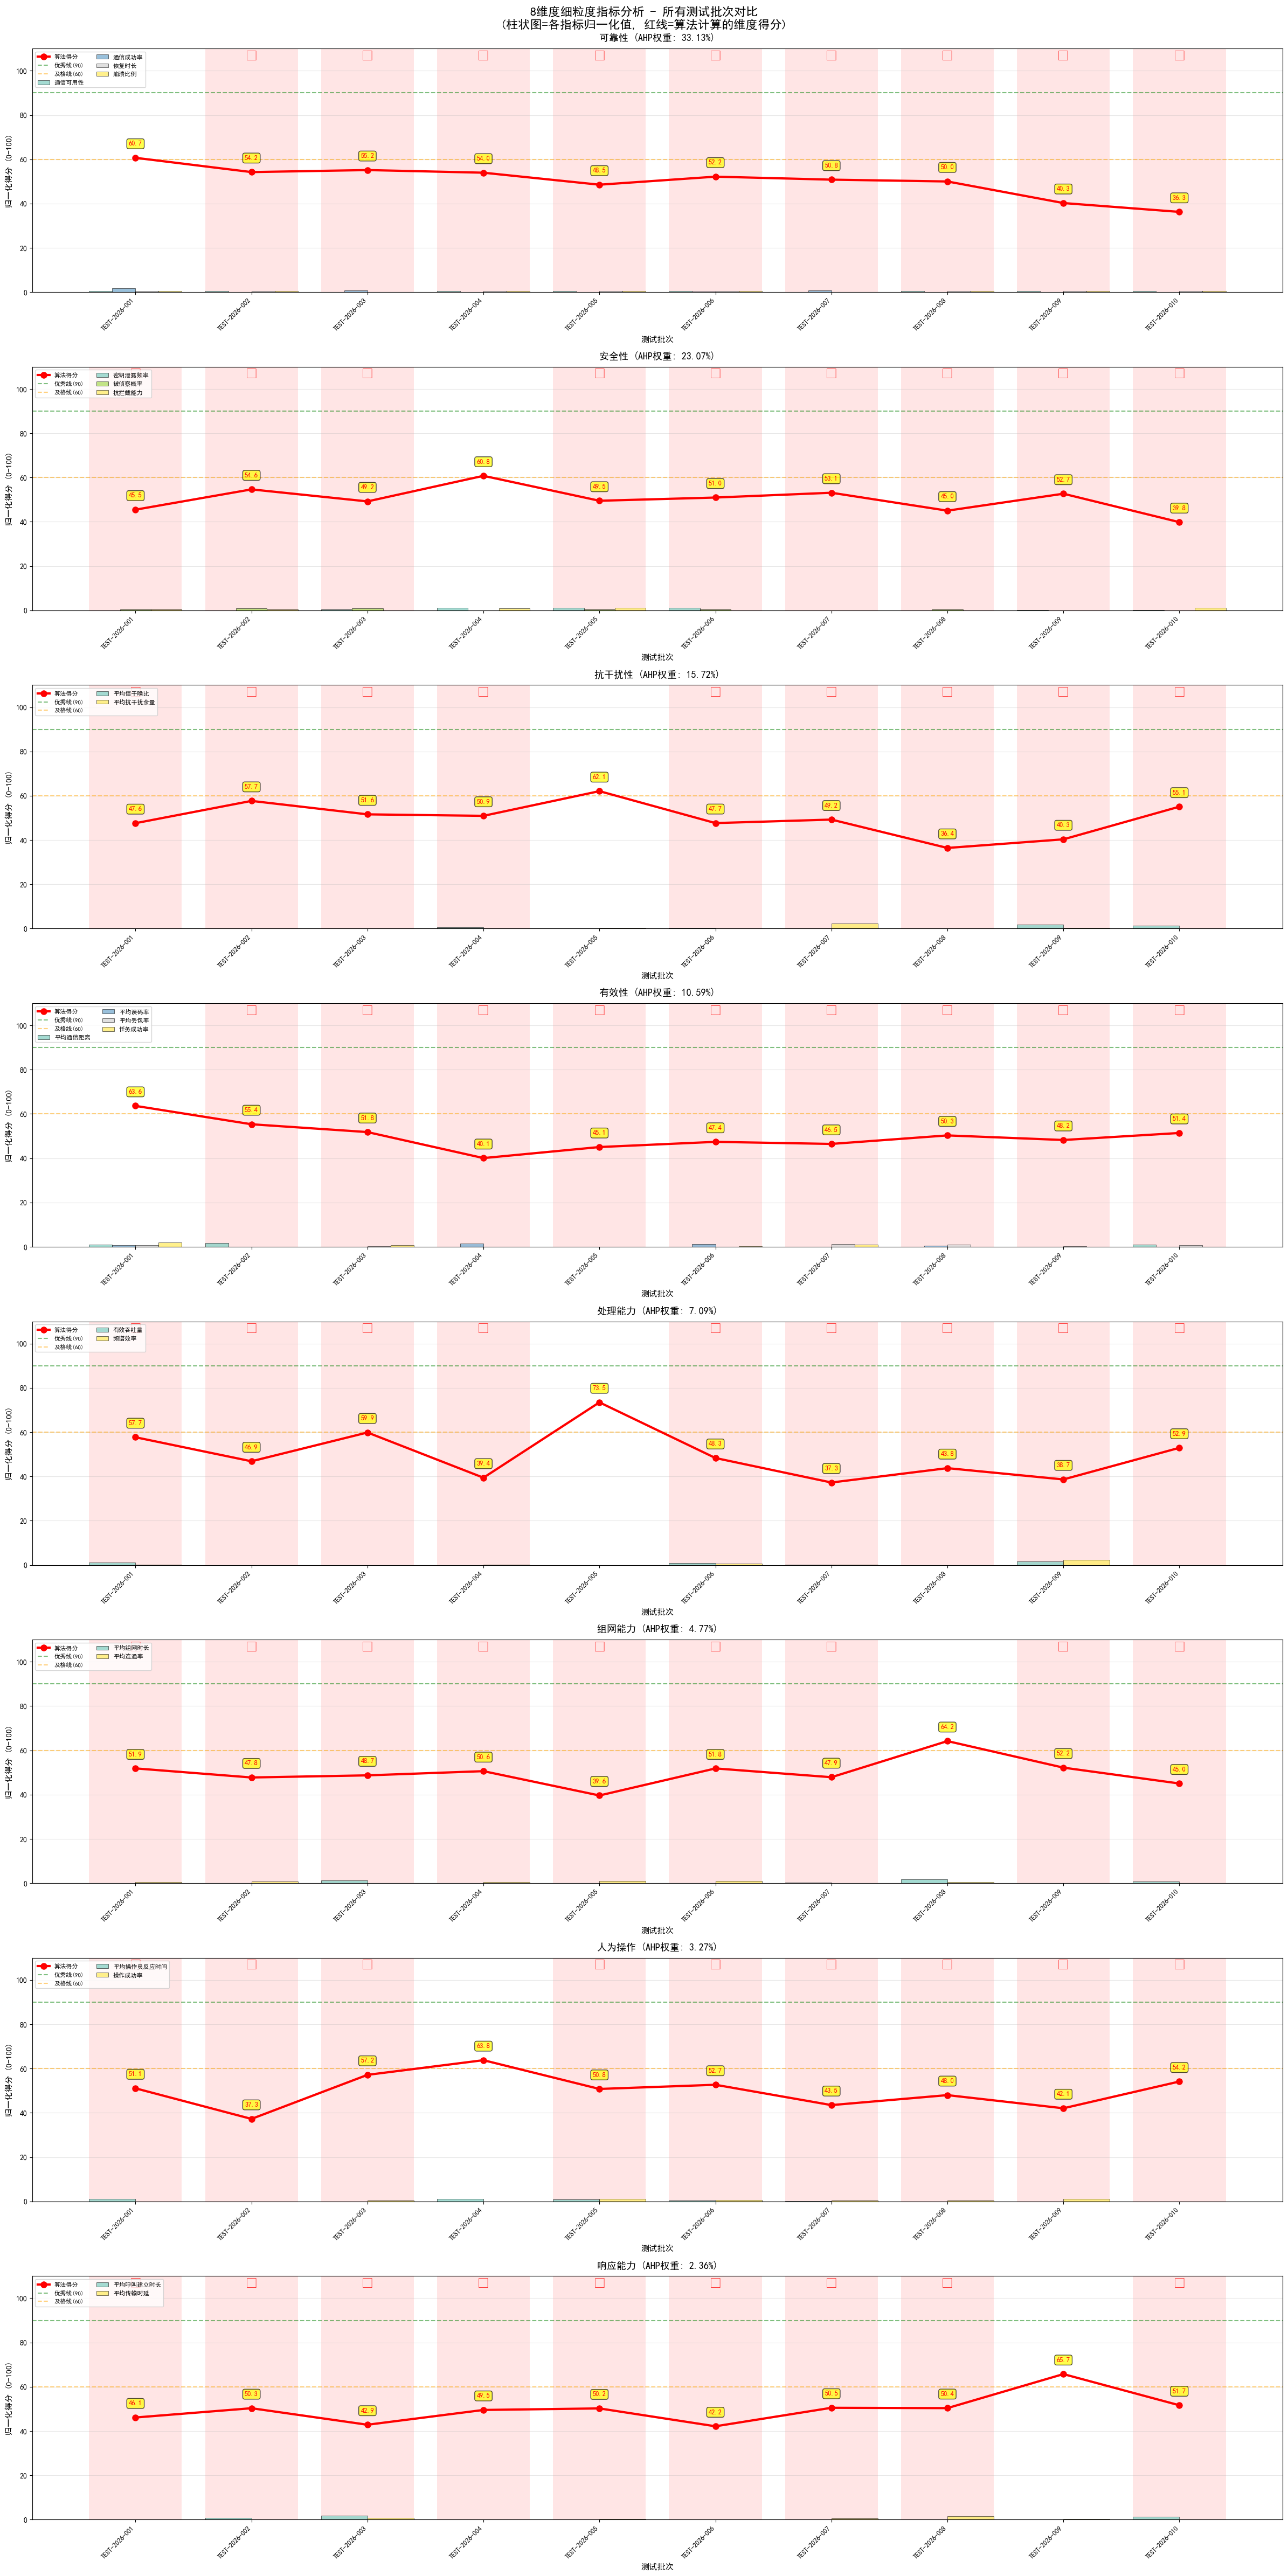


全部评估流程完成！


In [16]:
print("\n" + "="*80)
print("步骤9: 8维度细粒度指标可视化")
print("="*80)
print("绘制8个维度的细粒度指标对比图...")
print("说明: 使用前面计算的AHP权重和算法得分")
print()

from matplotlib.patches import Rectangle

# 创建8个子图（每行一个维度，显示更大）
fig = plt.figure(figsize=(24, 48))

# 使用前面定义的INDICATOR_SYSTEM和计算的criteria_weights
for idx, dim_code in enumerate(dim_codes_ordered, 1):
    dim_info = INDICATOR_SYSTEM[dim_code]
    dim_weight = criteria_weights[idx-1]  # 使用AHP计算的权重
    ax = plt.subplot(8, 1, idx)  # 8行1列，每行一个维度
    
    # 从INDICATOR_SYSTEM获取指标信息
    indicators = [ind['code'] for ind in dim_info['indicators']]
    labels = [ind['name'] for ind in dim_info['indicators']]
    n_indicators = len(indicators)
    n_tests = len(df_normalized)
    
    # 准备数据
    test_ids = df_normalized['test_id'].values
    dim_scores = df_scores[f'{dim_code}_score'].values  # 使用前面计算的维度得分
    
    # 设置柱状图参数
    x = np.arange(n_tests)
    width = 0.8 / n_indicators
    colors = plt.cm.Set3(np.linspace(0, 1, n_indicators))
    
    # 绘制分组柱状图
    for i, (indicator, label) in enumerate(zip(indicators, labels)):
        values = df_normalized[indicator].values
        offset = (i - n_indicators/2 + 0.5) * width
        bars = ax.bar(x + offset, values, width, label=label, 
                     color=colors[i], alpha=0.8, edgecolor='black', linewidth=0.5)
        
        # 在柱子上标注数值（只标注大于5的值）
        for j, (bar, val) in enumerate(zip(bars, values)):
            if val > 5:
                ax.text(bar.get_x() + bar.get_width()/2, val + 2, 
                       f'{val:.0f}', ha='center', va='bottom', fontsize=7)
    
    # 添加维度得分线（算法计算的得分）
    ax.plot(x, dim_scores, 'r-o', linewidth=3, markersize=8, 
           label=f'算法得分', zorder=10)
    
    # 在得分线上标注分数
    for i, (xi, score) in enumerate(zip(x, dim_scores)):
        ax.text(xi, score + 5, f'{score:.1f}', ha='center', va='bottom',
               fontsize=9, weight='bold', color='red',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
    
    # 添加参考线
    ax.axhline(y=90, color='green', linestyle='--', linewidth=1.5, alpha=0.5, label='优秀线(90)')
    ax.axhline(y=60, color='orange', linestyle='--', linewidth=1.5, alpha=0.5, label='及格线(60)')
    
    # 设置坐标轴
    ax.set_xlabel('测试批次', fontsize=11, weight='bold')
    ax.set_ylabel('归一化得分 (0-100)', fontsize=11, weight='bold')
    ax.set_title(f'{dim_info["name"]} (AHP权重: {dim_weight*100:.2f}%)', 
                fontsize=13, weight='bold', pad=10)
    ax.set_xticks(x)
    ax.set_xticklabels(test_ids, rotation=45, ha='right', fontsize=9)
    ax.set_ylim(0, 110)
    ax.legend(loc='upper left', fontsize=8, ncol=2)
    ax.grid(axis='y', alpha=0.3)
    
    # 高亮显示得分异常的测试（低于60分）
    for i, score in enumerate(dim_scores):
        if score < 60:
            # 添加红色背景标记
            rect = Rectangle((x[i]-0.4, 0), 0.8, 110, 
                           facecolor='red', alpha=0.1, zorder=0)
            ax.add_patch(rect)
            ax.text(x[i], 105, '⚠', ha='center', fontsize=16, color='red')

plt.suptitle('8维度细粒度指标分析 - 所有测试批次对比\n(柱状图=各指标归一化值, 红线=算法计算的维度得分)', 
            fontsize=16, weight='bold', y=0.995)
plt.tight_layout()

# 保存图片
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
save_path = f'8维度细粒度指标分析_{timestamp}.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"✓ 图表已保存: {save_path}")

# 生成详细分析报告
print("\n" + "="*80)
print("【8维度细粒度分析报告】")
print("="*80)

for i, dim_code in enumerate(dim_codes_ordered):
    dim_info = INDICATOR_SYSTEM[dim_code]
    dim_weight = criteria_weights[i]  # 使用AHP计算的权重
    
    print(f"\n【{dim_info['name']}】AHP权重: {dim_weight*100:.2f}%")
    print("-"*80)
    
    # 获取该维度的数据
    dim_data = df_scores[['test_id', f'{dim_code}_score']].copy()
    
    # 添加细分指标
    for indicator in dim_info['indicators']:
        dim_data[indicator['code']] = df_normalized[indicator['code']]
    
    dim_data = dim_data.sort_values(f'{dim_code}_score', ascending=False)
    
    print("\n排名:")
    for rank, (idx, row) in enumerate(dim_data.iterrows(), 1):
        score = row[f'{dim_code}_score']
        test_id = row['test_id']
        
        if score >= 90:
            grade = "⭐⭐⭐⭐⭐ 优秀"
        elif score >= 80:
            grade = "⭐⭐⭐⭐ 良好"
        elif score >= 70:
            grade = "⭐⭐⭐ 中等"
        elif score >= 60:
            grade = "⭐⭐ 及格"
        else:
            grade = "⚠ 不及格"
        
        print(f"  {rank}. {test_id}: {score:.2f}分 {grade}")
        
        # 显示各指标得分
        indicator_scores = []
        for indicator in dim_info['indicators']:
            code = indicator['code']
            name = indicator['name']
            val = row[code]
            indicator_scores.append(f"{name}={val:.1f}")
        print(f"     细分: {', '.join(indicator_scores)}")
    
    # 分析异常值
    print("\n⚠ 需要关注的问题:")
    has_issues = False
    for idx, row in dim_data.iterrows():
        test_id = row['test_id']
        issues = []
        
        for indicator in dim_info['indicators']:
            code = indicator['code']
            name = indicator['name']
            val = row[code]
            if val < 40:
                issues.append(f"{name}过低({val:.1f})")
        
        if issues:
            print(f"  - {test_id}: {', '.join(issues)}")
            has_issues = True
    
    if not has_issues:
        print("  无明显问题 ✓")

print("\n" + "="*80)
print("可视化分析完成！")
print("="*80)
print("\n说明:")
print("  1. 柱状图显示各指标的归一化值（0-100分）")
print("  2. 红色折线显示算法计算的维度综合得分")
print("  3. 绿色虚线(90分)表示优秀线，橙色虚线(60分)表示及格线")
print("  4. 红色背景标记表示该测试批次在此维度得分不及格(<60分)")
print("  5. 黄色标签显示算法计算的具体得分，可用于验证算法合理性")
print()
print("💡 验证建议:")
print("  - 检查红线(算法得分)是否与柱状图(指标值)趋势一致")
print("  - 如果某个测试批次所有指标都很高，但算法得分很低，说明权重可能有问题")
print("  - 如果某个测试批次有明显短板(某个指标很低)，算法得分应该受到影响")
print()

plt.show()

print("\n" + "="*80)
print("全部评估流程完成！")
print("="*80)